In [183]:
# Plotly credentials stuff- run first time only
# import plotly
# plotly.tools.set_credentials_file(username='bdesnoy', api_key='VLNSHIH0dfFWjlXNEbiG')
# plotly.tools.set_credentials_file(username='junyi', api_key='sswCNaXW5ssm3JllQCRq')


 

In [229]:
import numpy as np
import pandas as pd
import plotly.plotly as py
from re import match

# Load the Dataset

In [230]:
data = pd.read_csv('behavioral_risk_factor_dataset.csv')

In [231]:
# Convert question to a category and rename categories for visibility
data["Question"] = data["Question"].astype("category")
data['Question'].cat.categories = ["% Overweight Adults",
                                   "% Obese Adults",
                                   "% Mod Aerobic", 
                                   "% Mod Aerobic & Strength", 
                                   "% Vigerous Aerobic", 
                                   "% Strength", 
                                   "% No Phys. Activity", 
                                   "% < 1 Fruit / Day", 
                                   "% < 1 Veg / Day"]

# Drop, unnecessary columns to make table human-readable
cols_to_drop = ['Datasource', 'Class', 'Topic', 'Data_Value_Unit', 
                'Data_Value_Type', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 
                'Data_Value_Footnote', 'Total', 'Age(years)', 'Education',
                'Gender', 'Income', 'Race/Ethnicity', 'ClassID', 
                'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID']
data.drop(cols_to_drop, axis = 1, inplace = True)

In [232]:
list(data.columns)

['YearStart',
 'YearEnd',
 'LocationAbbr',
 'LocationDesc',
 'Question',
 'Data_Value',
 'Low_Confidence_Limit',
 'High_Confidence_Limit ',
 'Sample_Size',
 'GeoLocation',
 'StratificationCategory1',
 'Stratification1',
 'StratificationCategoryId1',
 'StratificationID1']

# Grab 2016 Data

In [233]:
data_2016 = data.query('YearStart == "2016"')
# remove 'Guam' ,'Puerto Rico', 'Virgin Islands'
data_2016 = data_2016[data_2016.LocationAbbr != 'VI']
data_2016 = data_2016[data_2016.LocationAbbr != 'PR']
data_2016 = data_2016[data_2016.LocationAbbr != 'GU']

#data_2016

# Visualizing Obesity by Location

In [234]:
def get_total_incidence_table(df, question):
    filtered_data = df.query('StratificationCategory1 == "Total" & Question == "%s"' % (question,))
    filtered_data = filtered_data.query('LocationAbbr != "US"')
    return filtered_data

In [235]:
obesity_data_by_state = get_total_incidence_table(data_2016, "% Obese Adults")
#obesity_data_by_state

In [236]:
##https://plot.ly/python/matplotlib-colorscales/
## use matplotlib style colorscales

import matplotlib
from matplotlib import cm

magma_cmap = matplotlib.cm.get_cmap('magma')
viridis_cmap = matplotlib.cm.get_cmap('viridis')

viridis_rgb = []
magma_rgb = []
norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

for i in range(0, 255):
       k = matplotlib.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
       magma_rgb.append(k)

for i in range(0, 255):
       k = matplotlib.colors.colorConverter.to_rgb(viridis_cmap(norm(i)))
       viridis_rgb.append(k)
    
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 255)
viridis = matplotlib_to_plotly(viridis_cmap, 255)


In [237]:
lat_long_regex = "\((-{0,1}[0-9]+.{0,1}[0-9]*),\s*(-{0,1}[0-9]+.{0,1}[0-9]*)\)"
def extract_lat_long(str):
    lat_long_match = match(lat_long_regex, str)
    return lat_long_match.groups()

def extract_lat(str):
    return float(extract_lat_long(str)[0])

def extract_long(str):
    return float(extract_lat_long(str)[1])

extract_lats = np.vectorize(extract_lat)
extract_longs = np.vectorize(extract_long)

In [244]:
# See Plotly Support: https://plot.ly/pandas/scatter-plots-on-maps/

def plot_basic(df, plot_title, bar_title, filename, style=magma):
    # Extract relevant data from dataframe
    locs = df["GeoLocation"]
    state_names = df["LocationDesc"] + ' (' +  df["Data_Value"].astype('str') + '%)'
    values = pd.to_numeric(df["Data_Value"])
    max_value = values.max()
    min_value = values.min()
    
    # Create a heat-map scale w/ colors for percentages
    state_marker = {'size': 8, 
                    'opacity': 0.8, 
                    'symbol': 'square', 
                    'line': {'width': 1, 
                             'color': 'rgba(102, 102, 102)'}, 
                    'cmin': min_value,
                    'cmax': max_value, 
                    'colorbar': {'title': bar_title}}
    state_bar = {
        'title': bar_title
    }
    plot_data = {'type': 'choropleth', 
                 'reversescale': True, 
                 'colorscale': magma,
                 'locationmode': 'USA-states', 
                 'locations': df["LocationAbbr"],
                 'z': values,
                 'text': state_names, 
                 'mode': 'markers', 
                 'marker': state_marker,
                 'colorbar': state_bar}
        
    plot_layout = {'title': '<b>%s</b><br>(hover for state name and value)' % (plot_title,),
                   'colorbar': True, 
                   'width': 1400,
                   'height': 800,
                   'geo': {'scope': 'usa', 
                           'projection': {'type': 'albers usa'}, 
                           'showland': True, 
                           'landcolor': "rgb(250, 250, 250)",
                           'subunitcolor': "rgb(217, 217, 217)",
                           'countrycolor': "rgb(217, 217, 217)", 
                           'countrywidth': 0.5, 
                           'subunitwidth': 0.5}
                  }

    fig = dict(data=[plot_data], layout=plot_layout)
    return fig

# direct to a plot.ly page with the plot
def plot_on_web(df, plot_title, bar_title, filename):
    fig = plot_basic(df, plot_title, bar_title, filename)
    url = py.plot(fig, validate=False, filename=filename)

# show the plot
def plot_on_notebook(df, plot_title, bar_title, filename, style=magma):
    fig = plot_basic(df, plot_title, bar_title, filename)
    py.image.ishow(fig)

# save plot to <filename>.png
def save_plot(df, plot_title, bar_title, filename, style=magma):
    fig = plot_basic(df, plot_title, bar_title, filename, style)
    filename += '.png'
    py.image.save_as(fig, filename=filename)


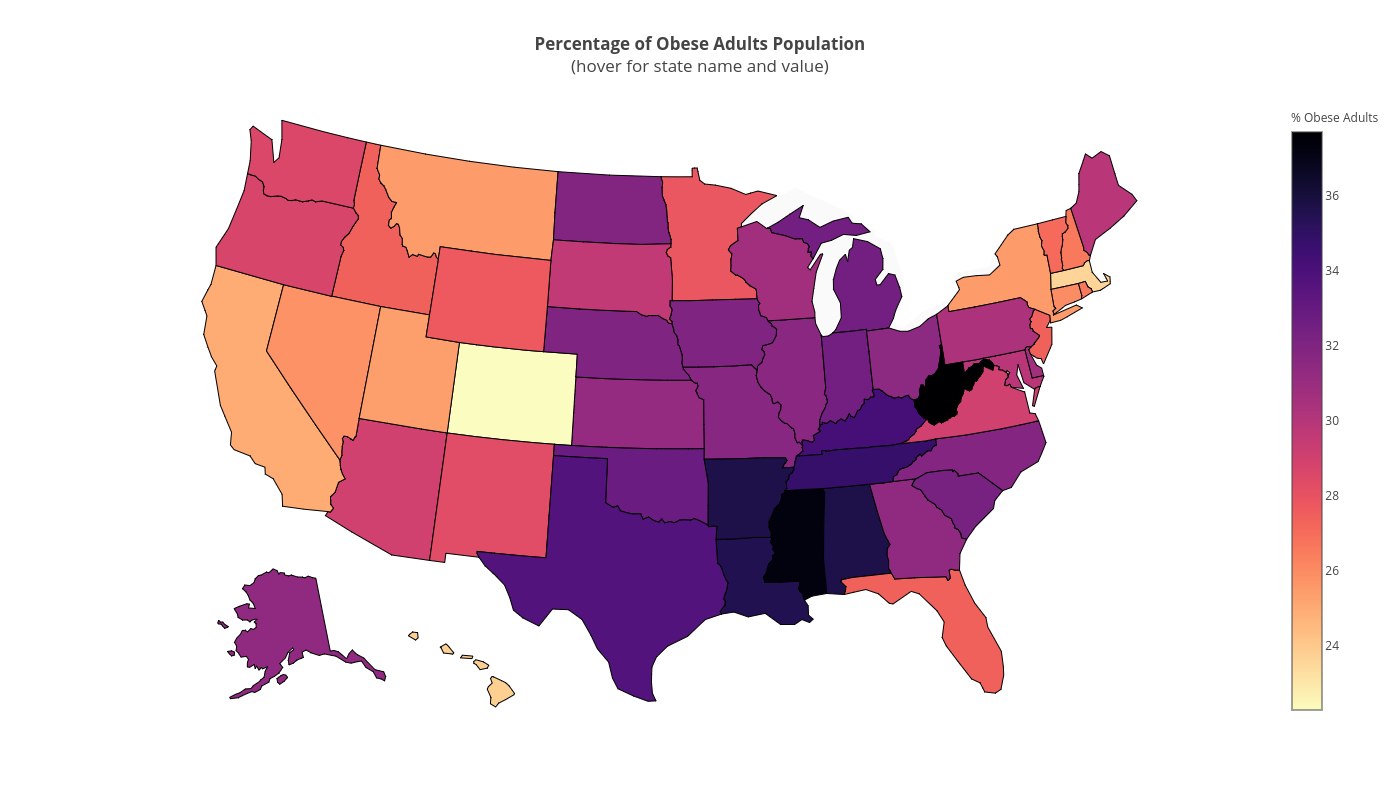

In [239]:
plot_on_notebook(obesity_data_by_state, 
          'Percentage of Obese Adults Population', 
          '% Obese Adults', 
          'd3-obesity')

save_plot(obesity_data_by_state, 
          'Percentage of Obese Adults Population', 
          '% Obese Adults', 
          'd3-obesity')

# Visualizing Overweight Incidence (inc. Obesity) by Location

In [240]:
# Use grouping to get the actual number of overweight adults by state
overwieght_obesity_data = data_2016.query('StratificationCategory1 == "Total" & (Question == "% Overweight Adults" | Question == "% Obese Adults")')
overwieght_obesity_data = overwieght_obesity_data.query('LocationAbbr != "US"')
overweight_obesity_sum_by_state = overwieght_obesity_data.groupby(['LocationAbbr'])['Data_Value'].sum()
overwieght_obesity_data

,YearStart,YearEnd,LocationAbbr,LocationDesc,Question,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
48828,2016,2016,AL,Alabama,% Overweight Adults,33.9,32.3,35.4,6526.0,"(32.84057112200048, -86.63186076199969)",Total,Total,OVR,OVERALL
48829,2016,2016,AK,Alaska,% Overweight Adults,35.3,32.4,38.2,2739.0,"(64.84507995700051, -147.72205903599973)",Total,Total,OVR,OVERALL
48830,2016,2016,AZ,Arizona,% Overweight Adults,34.2,32.7,35.8,10033.0,"(34.865970280000454, -111.76381127699972)",Total,Total,OVR,OVERALL
48831,2016,2016,AR,Arkansas,% Overweight Adults,32.5,30.2,34.9,4859.0,"(34.74865012400045, -92.27449074299966)",Total,Total,OVR,OVERALL
48832,2016,2016,CA,California,% Overweight Adults,36.0,34.8,37.2,10352.0,"(37.63864012300047, -120.99999953799971)",Total,Total,OVR,OVERALL
48833,2016,2016,CO,Colorado,% Overweight Adults,35.8,34.8,36.9,13637.0,"(38.843840757000464, -106.13361092099967)",Total,Total,OVR,OVERALL
48834,2016,2016,CT,Connecticut,% Overweight Adults,35.9,34.5,37.2,9960.0,"(41.56266102000046, -72.64984095199964)",Total,Total,OVR,OVERALL
48835,2016,2016,DE,Delaware,% Overweight Adults,37.3,35.2,39.5,3702.0,"(39.008830667000495, -75.57774116799965)",Total,Total,OVR,OVERALL
48836,2016,2016,DC,District of Columbia,% Overweight Adults,30.8,28.9,32.9,3479.0,"(38.89037138500049, -77.03196112699965)",Total,Total,OVR,OVERALL
48837,2016,2016,FL,Florida,% Overweight Adults,35.8,34.7,36.9,33186.0,"(28.932040377000476, -81.92896053899966)",Total,Total,OVR,OVERALL


In [227]:
# overweight_data_by_state = get_total_incidence_table(data_2016, "% Overweight Adults")
# overweight_data_by_state.set_index('LocationAbbr', inplace=True)
# overweight_data_by_state['Data_Value'] = overweight_obesity_sum_by_state
# overweight_data_by_state

# this one is broken.. not sure how to fix it.

In [241]:
save_plot(overwieght_obesity_data, 
           'Overweight Adults by Location', 
           '% Overwieght Adults', 
           'd3-overweight')

# Visualizing Inactivity by Location

In [242]:
inactivity_data_by_state = get_total_incidence_table(data_2016, "% No Phys. Activity") ## use data only in 2016?
# inactivity_data_by_state

In [243]:
save_plot(inactivity_data_by_state, 
           'Inactivity by Location', 
           '% Adults w/o Phys. Activity', 
           'd3-inactive')

# Visualizing Vegetable Malnutrition by Location

In [159]:
veg_data_by_state = get_total_incidence_table(data, "% < 1 Veg / Day")
#veg_data_by_state

In [245]:
save_plot(veg_data_by_state, 
           'Vegetable Malnutrition by Location', 
           '% Adults < 1 Veg / Day', 
           'd3-veg', viridis)

TypeError: save_plot() takes 4 positional arguments but 5 were given

# Visualizing Fruit Malnutrition by Location

In [163]:
fruit_data_by_state = get_total_incidence_table(data, "% < 1 Fruit / Day")
#fruit_data_by_state

In [187]:
save_plot(fruit_data_by_state, 
           'Fruit Malnutrition by Location', 
           '% Adults < 1 Fruit / Day', 
           'd3-fruit')